In [64]:
import pandas as pd
from seaborn import pairplot
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('data.csv')
print(data.shape)

(3748, 11)


(2602, 11)
acousticness        0
danceability        0
energy              0
id                  0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
genre               0
dtype: int64
Genres:
Unique Genres: ['rap' 'jazz' 'pop' 'rock' 'classical']
Number of Unique Genres: 5
(3748, 11)


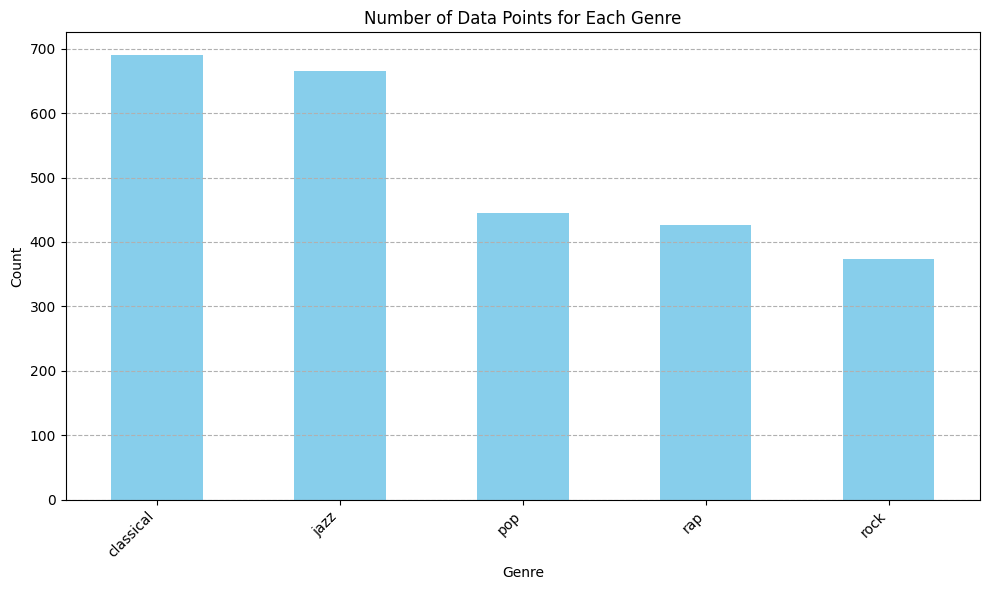

In [81]:
#Handle Dupes
dataNoDupe = data[~data.duplicated(subset='id', keep=False)]
print(dataNoDupe.shape)
#check for null
print(dataNoDupe.isnull().sum())
print("Genres:")
unique_genres = dataNoDupe['genre'].unique()
num_genres = len(unique_genres)
print(f"Unique Genres: {unique_genres}")
print(f"Number of Unique Genres: {num_genres}")
print(data.shape)
genre_counts = dataNoDupe['genre'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Data Points for Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

In [71]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_scale = ['loudness', 'tempo']

dataNoDupe[columns_to_scale] = scaler.fit_transform(dataNoDupe[columns_to_scale])
# pairplot(data, hue='genre')
# plt.savefig('scaled_pariplot.png')
data_labels = dataNoDupe['genre']
dataNoDupe = dataNoDupe.drop(columns=['id', 'genre'])

dataNoDupe.head()

/var/folders/k5/kwnm67cj11j95x28sdwr66dw0000gn/T/ipykernel_46469/171847736.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNoDupe[columns_to_scale] = scaler.fit_transform(dataNoDupe[columns_to_scale])


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
5,0.301000,0.876,0.486,0.00000,0.2820,0.743589,0.5110,0.579619,0.553
6,0.674000,0.416,0.429,0.03200,0.1120,0.608010,0.0438,0.508490,0.118
10,0.000959,0.946,0.430,0.00000,0.0761,0.806820,0.1240,0.399326,0.613
14,0.007050,0.817,0.653,0.00591,0.0690,0.809701,0.0580,0.500549,0.684
21,0.000959,0.946,0.430,0.00000,0.0761,0.806820,0.1240,0.399326,0.613


In [72]:
from sklearn.neighbors import LocalOutlierFactor

# Fit Local Outlier Factor (LOF)
# n_neighbors=10: checking the 10 nearest neighbors
# novelty=False: used to fit LOF model on training data
contamination = 0.05

lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination)  #

# Fit and predict outliers (-1 for outlier, 1 for inliers)
dataNoDupe['outlier_lof'] = lof.fit_predict(dataNoDupe)

# Mark the outliers
outliers_lof = dataNoDupe[dataNoDupe['outlier_lof'] == -1]

filtered_data = dataNoDupe[dataNoDupe['outlier_lof'] == 1].copy()
filtered_data.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,outlier_lof
5,0.301000,0.876,0.486,0.00000,0.2820,0.743589,0.5110,0.579619,0.553,1
6,0.674000,0.416,0.429,0.03200,0.1120,0.608010,0.0438,0.508490,0.118,1
10,0.000959,0.946,0.430,0.00000,0.0761,0.806820,0.1240,0.399326,0.613,1
14,0.007050,0.817,0.653,0.00591,0.0690,0.809701,0.0580,0.500549,0.684,1
21,0.000959,0.946,0.430,0.00000,0.0761,0.806820,0.1240,0.399326,0.613,1


   cluster      genre
0        0  classical
1        1       rock
2        2        rap
3        3       jazz
4        4  classical
   cluster  average_distance
0        0          0.414137
1        1          0.429144
2        2          0.478020
3        3          0.440691
4        4          0.795674


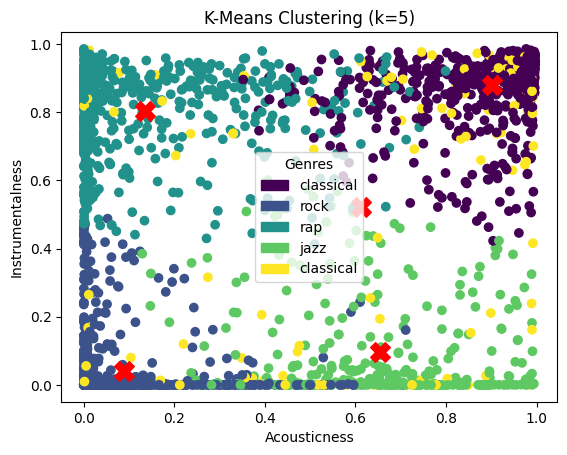

In [79]:
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches
kmeans = KMeans(n_clusters=5, random_state=1)
kmeans.fit(dataNoDupe)

# Accessing cluster labels and centroids
labels = kmeans.labels_
data_with_labels = dataNoDupe.copy()
data_with_labels['cluster'] = labels

# Add genre labels to the dataset
data_with_labels['genre'] = data_labels.values

# Group by cluster and get the most common genre in each cluster
cluster_genre = data_with_labels.groupby('cluster')['genre'].agg(lambda x: x.mode()[0]).reset_index()

# Print the most common genre for each cluster
print(cluster_genre)

# Calculate distances from each point to its centroid
distances = np.linalg.norm(dataNoDupe.values - kmeans.cluster_centers_[labels], axis=1)

# Add distances to the DataFrame
data_with_labels['distance_to_centroid'] = distances

# Calculate average distance for each cluster
average_distances = data_with_labels.groupby('cluster')['distance_to_centroid'].mean().reset_index()
average_distances.columns = ['cluster', 'average_distance']

# Print average distances to centroids
print(average_distances)

# Plotting the data
centroids = kmeans.cluster_centers_
scatter = plt.scatter(dataNoDupe["acousticness"], dataNoDupe["instrumentalness"], c=labels, cmap='viridis')

# Plot centroids
plt.scatter(centroids[:, dataNoDupe.columns.get_loc("acousticness")], 
            centroids[:, dataNoDupe.columns.get_loc("instrumentalness")], 
            c='red', marker='X', s=200, label='Centroids')

# Create legend for genres
colors = scatter.get_array()  # Get the colors used in the scatter plot
unique_clusters = cluster_genre['cluster'].unique()

# Create patches for legend
legend_handles = []
for cluster in unique_clusters:
    genre = cluster_genre.loc[cluster_genre['cluster'] == cluster, 'genre'].values[0]
    color = scatter.cmap(scatter.norm(cluster))  # Get the color for the cluster
    legend_handles.append(mpatches.Patch(color=color, label=genre))

# Adding labels and title
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.legend(handles=legend_handles, title="Genres")
plt.show()

genre    classical  jazz  pop  rap  rock
cluster                                 
0              476   231   54   38     8
1               30    39  235  172   237
2               74   133  115  184   104
3               56   230   25   24     6
4               55    33   16    8    19


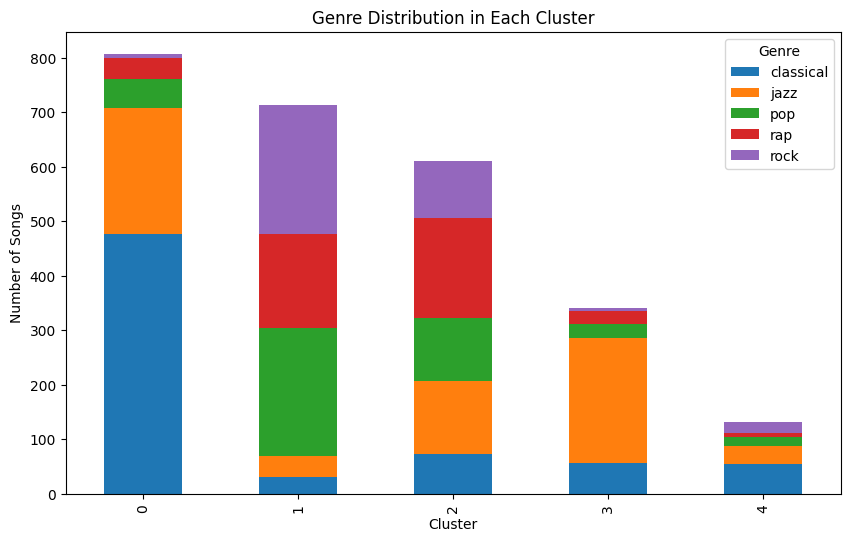

In [80]:
# Count the number of songs for each genre in each cluster
genre_distribution = data_with_labels.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Print the genre distribution
print(genre_distribution)

# If you want to visualize this, you can use a bar plot
genre_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Genre Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Songs')
plt.legend(title='Genre')
plt.show()

In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# columns_to_scale = ['loudness', 'tempo']

# data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

kmeans = KMeans(n_clusters=5)
kmeans.fit(dataNoDupe)

# Accessing cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plotting the data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(dataNoDupe["acousticness"], dataNoDupe["instrumentalness"], c=labels, cmap='viridis')
plt.scatter(centroids[:, dataNoDupe.columns.get_loc("acousticness")], 
            centroids[:, dataNoDupe.columns.get_loc("instrumentalness")], 
            c='red', marker='X', s=200, label='Centroids') 
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Fit Local Outlier Factor (LOF)
# n_neighbors=10: checking the 10 nearest neighbors
# novelty=False: used to fit LOF model on training data
contamination = 0.05

lof = LocalOutlierFactor(n_neighbors=10, contamination=contamination)  #

# Fit and predict outliers (-1 for outlier, 1 for inliers)
dataNoDupe['outlier_lof'] = lof.fit_predict(dataNoDupe)

# Mark the outliers
outliers_lof = dataNoDupe[dataNoDupe['outlier_lof'] == -1]

filtered_data = dataNoDupe[dataNoDupe['outlier_lof'] == 1].copy()

# Fit KMeans to the filtered data (inliers only)
kmeans = KMeans(n_clusters=5)
kmeans.fit(filtered_data)  # Only use relevant features for clustering

# Accessing cluster labels and centroids
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plot the filtered data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(filtered_data["acousticness"], filtered_data["instrumentalness"], c=labels, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,3], c='r')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()

In [ ]:
from sklearn.metrics import davies_bouldin_score
k_values = range(2,20)
db_score = []

for k in k_values:
    # Fit KMeans to the filtered data (inliers only)
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(filtered_data)  # Only use relevant features for clustering
    labels = kmeans.labels_
    db_score.append(davies_bouldin_score(filtered_data, labels))

min_db_score = min(db_score)
optimal_k = k_values[db_score.index(min_db_score)]
print(f"The optimal value of K is {optimal_k} with a Davies-Bouldin index of {min_db_score}")

# Plot the Davies-Bouldin index for each K
plt.plot(k_values, db_score, marker='o')
plt.title('Davies-Bouldin Index for Different Values of K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(k_values)
plt.grid()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Assuming filtered_data is your dataset
# DBSCAN with eps=1 and min_samples=5
model = DBSCAN(eps=0.3, min_samples=100).fit(filtered_data)
dbscan_labels = model.labels_
# print(dbscan_labels)

cluster_counts = pd.Series(dbscan_labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plotting the data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(filtered_data["acousticness"], filtered_data["instrumentalness"], c=dbscan_labels, cmap='viridis')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()


In [ ]:
# Plot k-distances
from sklearn.neighbors import NearestNeighbors
def k_distances2(X,n):
    neighbors = NearestNeighbors(n_neighbors=n)
    neighbors_fit = neighbors.fit(X)
    distances, indices = neighbors_fit.kneighbors(X)
    return distances, indices
# TODO: add your parameters here.
# data -- your normalized dataset
# k -- k-th neighbour. By default, k=count(features)+1
distances, indices = k_distances2(filtered_data,5)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.plot(range(3500), [0.22]*3500)
plt.show()


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(filtered_data)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=1)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit KMeans to the filtered data (inliers only)
GMM = GaussianMixture(n_components=5, covariance_type='full', random_state=1)
GMM.fit(filtered_data)  # Only use relevant features for clustering

# Accessing cluster labels and centroids
labels = GMM.predict(filtered_data)
centroids = kmeans.cluster_centers_
cluster_counts = pd.Series(labels).value_counts()
print(f"Cluster Counts:{cluster_counts}")
# Plot the filtered data using two features: "sw" (sepal width) and "sl" (sepal length)
plt.scatter(filtered_data["acousticness"], filtered_data["instrumentalness"], c=labels, cmap='viridis')
plt.scatter(centroids[:,0], centroids[:,3], c='r')
plt.xlabel('Acousticness')
plt.ylabel('Instrumentalness')
plt.title('K-Means Clustering (k=5)')
plt.show()